In [62]:
from customAudioDataset import collate_fn,pad_sequence
from torch.utils.data import DataLoader
import customAudioDataset as data
train_csv_path = "/mnt/lustre/sjtu/home/zkn02/EnCodec_Trainer/librispeech_train100h.csv"
train_dataset = data.CustomAudioDataset(train_csv_path,tensor_cut=1000000)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,pin_memory=True)

In [63]:
batch_data = next(iter(train_loader))
print(batch_data.shape)

torch.Size([4, 1, 266960])


In [64]:
import torchaudio
wav,sr = torchaudio.load("/mnt/lustre/sjtu/home/zkn02/data/LibriSpeech/train-clean-100/7794/295955/7794-295955-0003.flac")
print(wav.shape)
print(sr)

torch.Size([1, 255280])
16000


In [65]:
meta_data = torchaudio.info("/mnt/lustre/sjtu/home/zkn02/data/LibriSpeech/train-clean-100/7794/295955/7794-295955-0003.flac")
print(meta_data)

AudioMetaData(sample_rate=16000, num_frames=255280, num_channels=1, bits_per_sample=16, encoding=FLAC)


Matplotlib is building the font cache; this may take a moment.


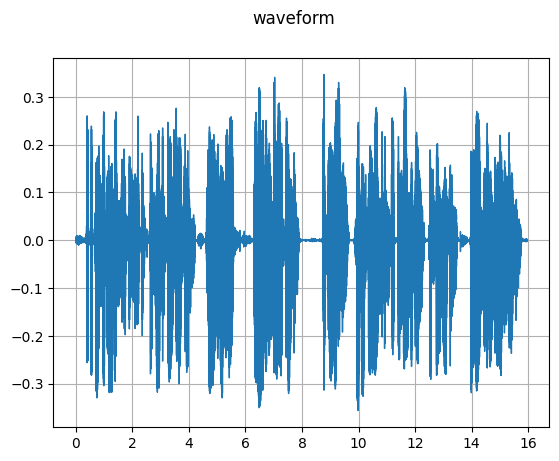

In [10]:
import torch
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
plot_waveform(wav, sr)    

In [66]:
from model import EncodecModel  
target_bandwidths = [1.5, 3.0, 6.0, 12.0,24.0]
sample_rate=24_000
channels=1
model = EncodecModel._get_model(
                target_bandwidths, sample_rate, channels,
                causal=False, model_norm='time_group_norm', audio_normalize=True,
                segment=1., name='my_encodec')

print(len(model(batch_data)))
print(model(batch_data)[0].shape)
print(model(batch_data)[1].shape)
print(len(model(batch_data)[2][0][0]) )

3
torch.Size([4, 1, 266960])
torch.Size([1])
4


In [35]:
import torch.nn as nn
print(batch_data.shape)
conv1d = nn.Conv1d(1, 32, kernel_size=7,stride=1)
print(conv1d(batch_data).shape)

torch.Size([4, 1, 10000])
torch.Size([4, 32, 9994])


In [72]:
children = []
for child_name, child in model.named_children():
    print(child_name)
    children.append(child)
encoder = children[0]
print(encoder.ratios)
# frames = encoder(batch_data)
# print(encoder(batch_data).shape)

quantizer = children[1]


encoder
quantizer
decoder
[2, 4, 5, 8]


In [49]:
frames = model.encode(batch_data)
print(type(frames))
print(len(frames[0]))
for i in frames[0]:
    print(i.shape)
print(frames[0][1])


<class 'list'>
2
torch.Size([4, 128, 32])
torch.Size([4, 1])
tensor([[0.0489],
        [0.0616],
        [0.0758],
        [0.0429]])


In [87]:
import typing as tp
import math
import numpy as np
EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]
_, channels, length = batch_data.shape
segment = 1.
sample_rate=24_000
normalize=True
training=True
bandwidth=[1.5, 3.0, 6.0, 12.0,24.0]
frame_rate=math.ceil(sample_rate / np.prod(encoder.ratios)) # 24000/320
def _encode_frame(x: torch.Tensor) -> EncodedFrame:
    length = x.shape[-1]
    duration = length / sample_rate
    assert segment is None or duration <= 1e-5 + segment

    if normalize: #就是传进去的audio_normalize
        mono = x.mean(dim=1, keepdim=True)
        volume = mono.pow(2).mean(dim=2, keepdim=True).sqrt()
        scale = 1e-8 + volume # [4,1,1] 
        x = x / scale
        scale = scale.view(-1, 1)# [4,1] 
    else:
        scale = None
    emb = encoder(x)
    # print(emb.shape)
    if training:# or True:
        print("training")
        print(emb.shape) # emb 和 codes的shape一样
        return emb, scale
    # TODO: 这里需要吗？
    codes = quantizer.encode(emb, frame_rate, bandwidth)
    codes = codes.transpose(0, 1)
    print(codes.shape)
    # codes is [B, K, T], with T frames, K nb of codebooks.
    return codes, scale

In [88]:
# model decode部分的测试

def segment_length(segment,sample_rate) -> tp.Optional[int]:
    if segment is None:
        return None
    return int(segment * sample_rate)

segment_length = segment_length(segment, sample_rate) # 24000
print(segment_length)

overlap = 0.01
def segment_stride(segment_length,overlap) -> tp.Optional[int]:
    segment_length = segment_length
    if segment_length is None:
        return None
    return max(1, int((1 - overlap) * segment_length))

segment_stride = segment_stride(segment_length,overlap) # 23760
print(segment_stride)

stride = segment_stride
encoded_frames: tp.List[EncodedFrame] = []
# print("length:", length, "stride:", stride)
for offset in range(0, length, stride):
    print("start:", offset, "end:", offset + segment_length)
    frame = batch_data[:, :, offset: offset + segment_length] # [B, C, segment_length]
    result=_encode_frame(frame)  # [4,128,75]
    print(result[0].shape)
    encoded_frames.append(result)
print(len(encoded_frames))




24000
23760
start: 0 end: 24000
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 23760 end: 47760
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 47520 end: 71520
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 71280 end: 95280
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 95040 end: 119040
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 118800 end: 142800
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 142560 end: 166560
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 166320 end: 190320
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 190080 end: 214080
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 213840 end: 237840
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 237600 end: 261600
training
torch.Size([4, 128, 75])
torch.Size([4, 128, 75])
start: 261360 end: 285360
training
torch.Size([4, 128, 18])
torch.

In [51]:
class Circle:
    def __init__(self, radius):
        self.radius = radius 

    @property
    def diameter(self):
        return self.radius * 2

    @property
    def area(self):
        return 3.14 * (self.radius ** 2)


In [52]:
circle = Circle(5)
print(circle.radius)
print(circle.diameter)
print(circle.area)

5
10
78.5
